# BCPNN perfect theory - Recall properties
Here we study the recall properties of the BCPNN with a super fast integration time (tau_m) very small and perfect softmax. 

In [1]:
import pprint
import subprocess
import sys 
sys.path.append('../')

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns

%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 12)

np.set_printoptions(suppress=True, precision=2)

sns.set(font_scale=3.0)

from network import Protocol, BCPNNModular, NetworkManager, BCPNNPefect
from plotting_functions import plot_weight_matrix, plot_state_variables_vs_time, plot_winning_pattern
from plotting_functions import plot_network_activity, plot_network_activity_angle
from analysis_functions import calculate_recall_time_quantities, calculate_angle_from_history
from connectivity_functions import artificial_connectivity_matrix

## A litlte bit of theory
If we have system with only one type of connectivity, and perfect softmax selectivity one state will be supprssed in favor of the other as soon as the support of the second state is bigger. In more detail, if we start with a system where the first unit is activated its own support will be $s_1 = g w_{self} - a(t)$ where a is the adaptation time. Where the adaptation current is increasing in time for as long as the first unit is activated. On the other hand the second unit is receiving a constant current to its support $s_2 = g w_{next}$, if this process continues by continuity there will be a point when:

$s_1 = s_2$

$gw_{self} - g_{a} (1 - e^{\frac{t}{\tau_a}}) =  g w_{next} $

Where we have subsituted the proper term for adaptation.

We can solve the equation equation above to obtain the recall time:

$T_{recall} = \tau_{a} \ln(\frac{g_a}{g_a - g_w (w_{self}  - w_{next})})$

We will test this relationship for different values of this parameters down here

#### General parameters

In [2]:
g_w_ampa = 2.0
g_w = 0.0 
g_a = 10.0
tau_a = 0.250
tau_z = 0.150
G = 1.0
sigma = 0.0

First let's create an artificial matrix where we have exact control over the values of $w_{next}$ and $w_{self}$

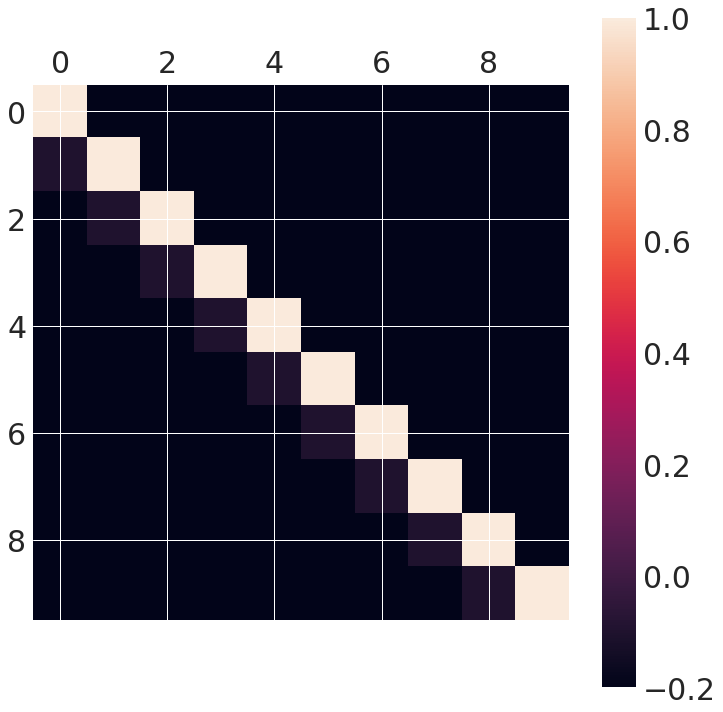

In [3]:
minicolumns = 10
w_self = 1.0
w_next = -0.1
w_rest = -0.2

def simple_bcpnn_matrix(minicolumns, w_self, w_next, w_rest):

    w = np.ones((minicolumns, minicolumns)) * w_rest
    for i in range(minicolumns):
        w[i, i] = w_self

    for i in range(minicolumns -1):
        w[i + 1, i] = w_next
        
    return w

w = simple_bcpnn_matrix(minicolumns, w_self, w_next, w_rest)
plt.matshow(w)
plt.colorbar();

In [4]:
# Patterns parameters
hypercolumns = 1
minicolumns = 10
n_patterns = 10

# Manager properties
dt = 0.001
values_to_save = ['o', 's', 'z_pre', 'z_post', 'a', 'i_ampa', 'i_nmda']
    
# Build the network
nn = BCPNNPefect(hypercolumns, minicolumns, g_w_ampa=g_w_ampa, g_w=g_w, g_a=g_a, tau_a=tau_a, 
                  sigma=sigma, G=G,
                z_transfer=False, diagonal_zero=False, strict_maximum=True, perfect=True)

# Build the manager
manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)
nn.w_ampa = w

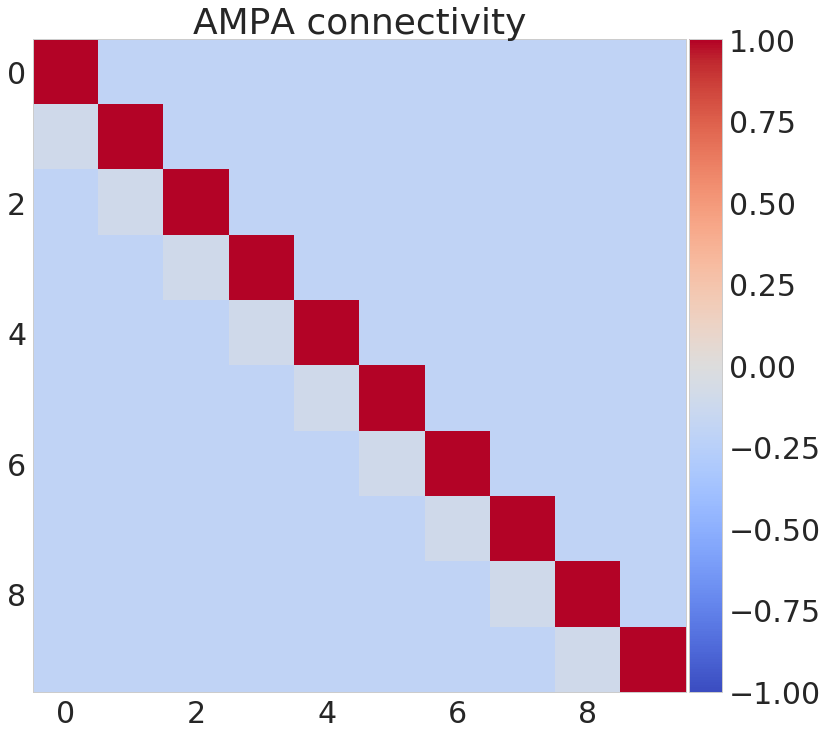

In [5]:
plot_weight_matrix(manager.nn, ampa=True)

Let's get the recall time, in order to do that let's first build a function that returns the recall time.

In [6]:
def simple_bcpnn_theo_recall_time(tau_a, g_a, g_w, w_next, w_self):
    
    delta_w = w_self - w_next
    return tau_a * np.log(g_a / (g_a - g_w * delta_w))

In [24]:
w_next

-0.1

In [25]:
simple_bcpnn_theo_recall_time(tau_a, g_a, g_w_ampa, w_next, w_self)

0.12770640594149768

success 100.0


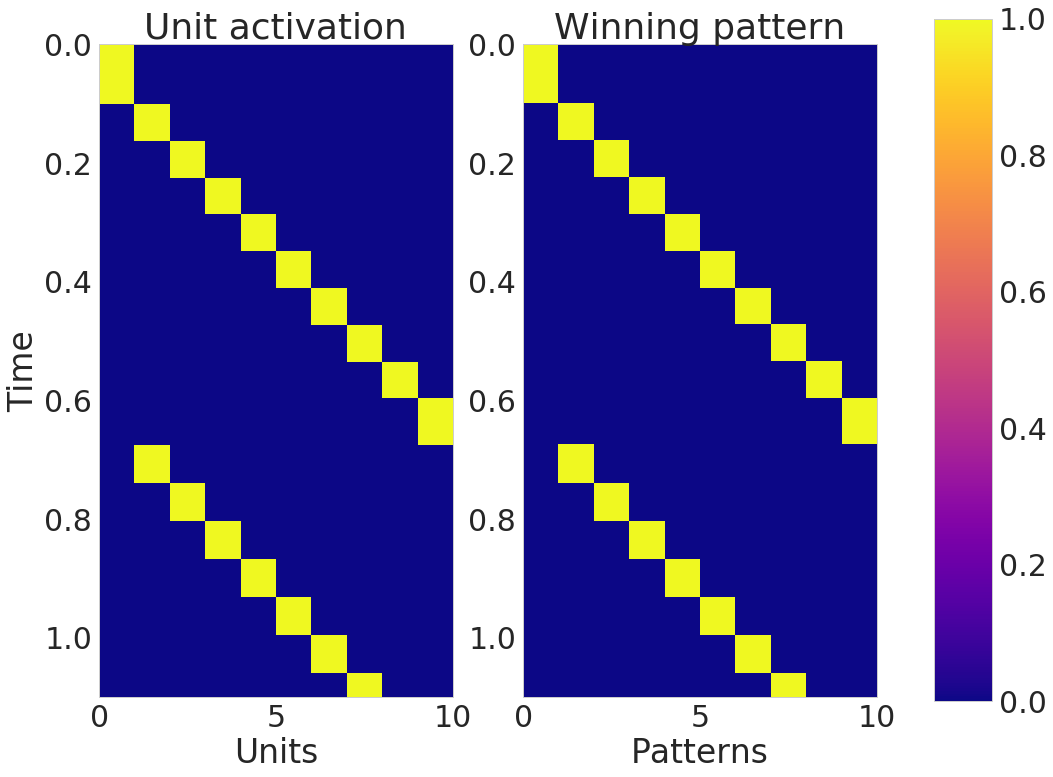

In [8]:
T_recall = 1.0
T_cue = 0.100
sequences = [[i for i in range(n_patterns)]]
n = 1

aux = calculate_recall_time_quantities(manager, T_recall, T_cue, n, sequences)
total_sequence_time, mean, std, success, timings = aux
plot_network_activity_angle(manager)
print('success', success)

## Complete example for testing

0.229072682969
0.23


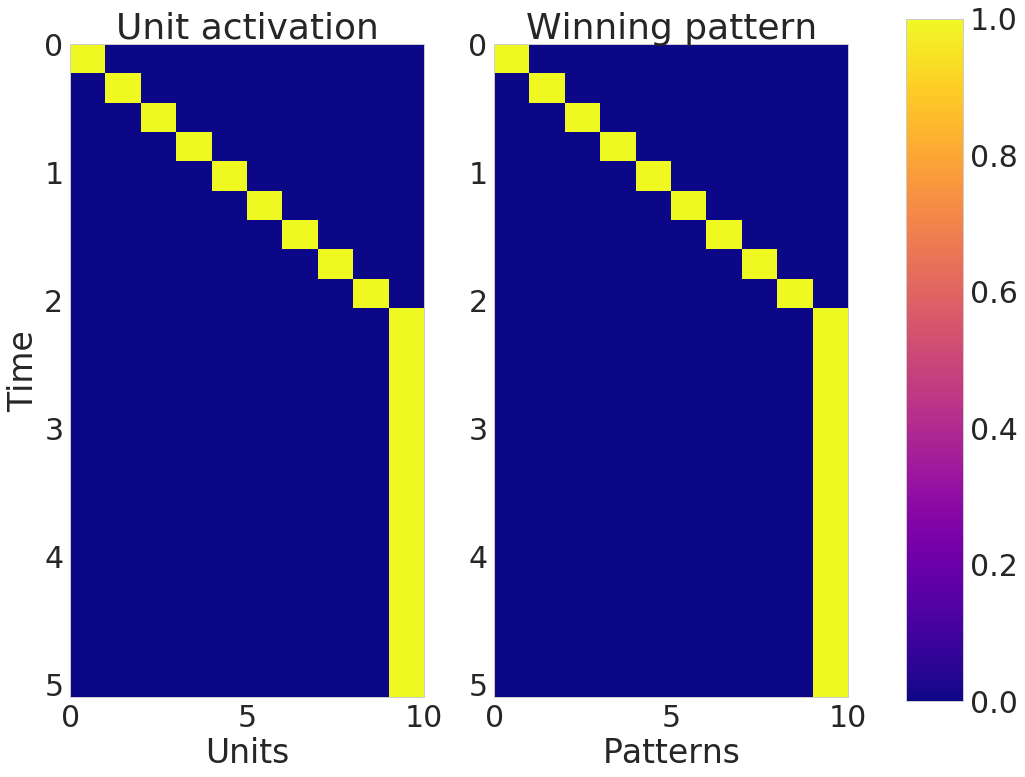

In [35]:
g_w_ampa = 2.0
g_w = 0.0 
g_a = 10.0
tau_a = 0.250
tau_z = 0.150
G = 1.0
sigma = 0.0

w_self = 1.0
w_next = -2
w_rest = -5

# Patterns parameters
hypercolumns = 1
minicolumns = 10
n_patterns = 10

nn = BCPNNPefect(hypercolumns, minicolumns, g_w_ampa=g_w_ampa, g_w=g_w, g_a=g_a, tau_a=tau_a, 
                  sigma=sigma, G=G,
                z_transfer=False, diagonal_zero=False, strict_maximum=True, perfect=True)

# Build the manager
manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)
w = simple_bcpnn_matrix(minicolumns, w_self, w_next, w_rest)
nn.w_ampa = w

# Recall
T_recall = 5.0
T_cue = 0.100
sequences = [[i for i in range(n_patterns)]]
n = 1

aux = calculate_recall_time_quantities(manager, T_recall, T_cue, n, sequences)
total_sequence_time, mean, std, success, timings = aux

T_theo = simple_bcpnn_theo_recall_time(tau_a, g_a, g_w_ampa, w_next, w_self)
plot_network_activity_angle(manager)
print(T_theo)
print(mean)

## Theoretical curve

In [9]:
g_w_ampa = 2.0
g_w = 0.0 
g_a = 10.0
tau_a = 0.250
tau_z = 0.150
G = 1.0
sigma = 0.0

w_self = 1.0
w_next = -0.1
w_rest = -0.2


T_recall_theorical = simple_bcpnn_theo_recall_time(tau_a, g_a, g_w, w_next, w_self)
print(T_recall_theorical)

0.0


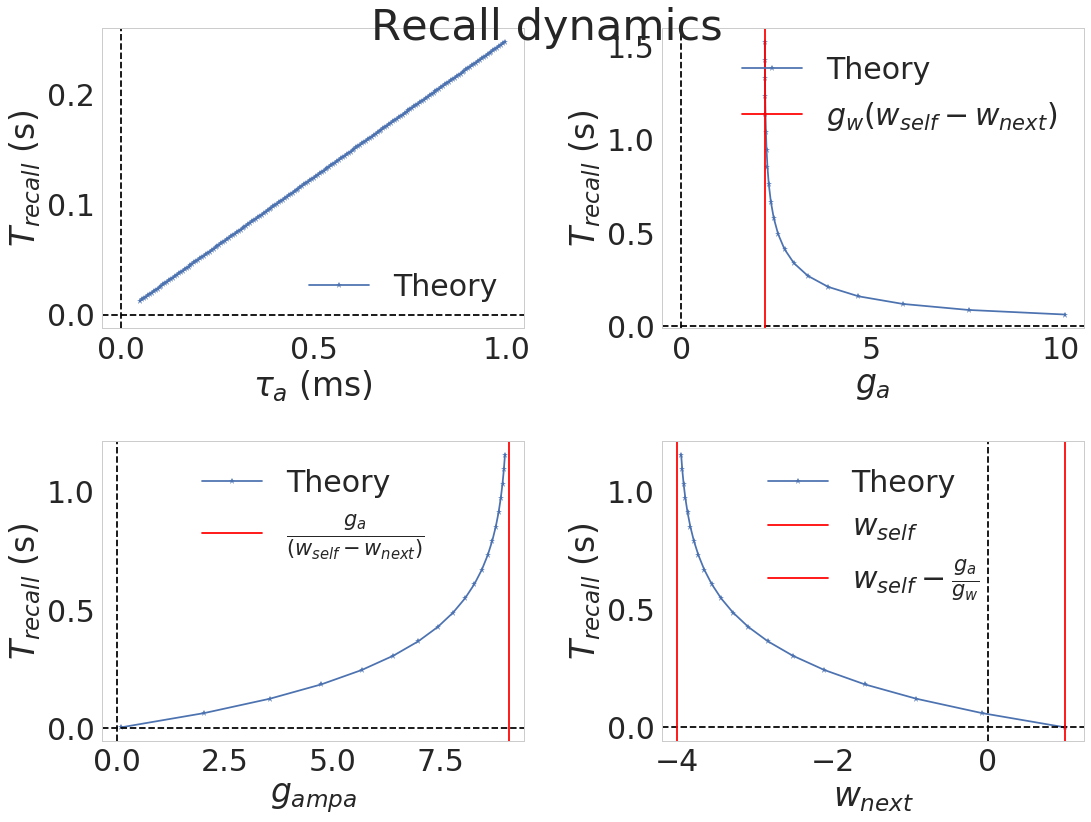

In [10]:
tau_a_vector = np.arange(0.050, 1.0, 0.005)
singularity = g_w_ampa * (w_self - w_next)
g_a_vector = singularity + np.logspace(-2, 1.2, 20) * 0.5
g_w_max = g_a / (w_self - w_next)
g_w_ampa_vector = g_w_max - np.logspace(-1, 1, 20) * 0.9
w_next_max = w_self
w_next_min = w_self - g_a / g_w_ampa 
w_next_vector = (w_next_max - w_next_min) * np.logspace(-2, 0, 20) + w_next_min

T_recall_theorical_tau_a = simple_bcpnn_theo_recall_time(tau_a_vector, g_a, g_w_ampa, w_next, w_self)
T_recall_theorical_g_a = simple_bcpnn_theo_recall_time(tau_a, g_a_vector, g_w_ampa, w_next, w_self)
T_recall_theorical_g_w_ampa = simple_bcpnn_theo_recall_time(tau_a, g_a, g_w_ampa_vector, w_next, w_self)
T_recall_theorical_w_next = simple_bcpnn_theo_recall_time(tau_a, g_a, g_w_ampa, w_next_vector, w_self)

fig = plt.figure(figsize=(16, 12))

ax1 = fig.add_subplot(221)
ax1.plot(tau_a_vector, T_recall_theorical_tau_a, '*-', label=r'Theory')
ax1.axhline(0, ls='--', color='black')
ax1.axvline(0, ls='--', color='black')
ax1.set_xlabel(r'$\tau_{a}$ (ms)')
ax1.set_ylabel(r'$T_{recall}$ (s)')
ax1.legend()

ax2 = fig.add_subplot(222)
ax2.plot(g_a_vector, T_recall_theorical_g_a, '*-', label=r'Theory')
ax2.axhline(0, ls='--', color='black')
ax2.axvline(0, ls='--', color='black')
ax2.axvline(singularity, ls='-', color='red', label=r'$g_{w}(w_{self} - w_{next})$')
ax2.set_xlabel(r'$g_{a}$')
ax2.set_ylabel(r'$T_{recall}$ (s)')
ax2.legend()


ax3 = fig.add_subplot(223)
ax3.plot(g_w_ampa_vector, T_recall_theorical_g_w_ampa, '*-', label=r'Theory')
ax3.axhline(0, ls='--', color='black')
ax3.axvline(0, ls='--', color='black')
ax3.set_xlabel(r'$g_{ampa}$')
ax3.set_ylabel(r'$T_{recall}$ (s)')
ax3.axvline(g_w_max, ls='-', color='red', label=r'$\frac{g_{a}}{(w_{self} - w_{next})}$')
ax3.legend()


ax4 = fig.add_subplot(224)
ax4.plot(w_next_vector, T_recall_theorical_w_next, '*-', label=r'Theory')
ax4.axhline(0, ls='--', color='black')
ax4.axvline(0, ls='--', color='black')
ax4.set_xlabel(r'$w_{next}$')
ax4.set_ylabel(r'$T_{recall}$ (s)')
ax4.axvline(w_next_max, ls='-', color='red', label=r'$w_{self}$')
ax4.axvline(w_next_min, ls='-', color='red', label=r'$w_{self} - \frac{g_a}{g_w}$')
ax4.legend()


fig.tight_layout()
fig.suptitle('Recall dynamics');


#### tau_a

In [16]:
# Patterns parameters
hypercolumns = 1
minicolumns = 10
n_patterns = 10

# Manager properties
dt = 0.001
values_to_save = ['o', 's', 'z_pre', 'z_post', 'a', 'i_ampa', 'i_nmda']
    
# Protocol
training_time = 0.100
inter_sequence_interval = 1.0
inter_pulse_interval = 0.0

tau_a_vector = np.linspace(0.050, 1.0, 10)
T_recall_vector_tau_a = np.zeros_like(tau_a_vector)
success_tau_a = np.zeros_like(tau_a_vector)
std_tau_a = np.zeros_like(tau_a_vector)

for index, tau_a_ in enumerate(tau_a_vector):
    
    # Build the network
    nn = BCPNNPefect(hypercolumns, minicolumns, g_w_ampa=g_w_ampa, g_w=g_w, g_a=g_a, tau_a=tau_a_, 
                      sigma=sigma, G=G,
                    z_transfer=False, diagonal_zero=False, strict_maximum=True, perfect=True)

    # Build the manager
    manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)
    w = simple_bcpnn_matrix(minicolumns, w_self, w_next, w_rest)
    nn.w_ampa = w

    # Recall
    T_recall = 1.0
    T_cue = 0.100
    sequences = [[i for i in range(n_patterns)]]
    n = 1

    aux = calculate_recall_time_quantities(manager, T_recall, T_cue, n, sequences)
    total_sequence_time, mean, std, success, timings = aux
    
    T_recall_vector_tau_a[index] = mean
    success_tau_a[index] = success
    std_tau_a[index] = std
    

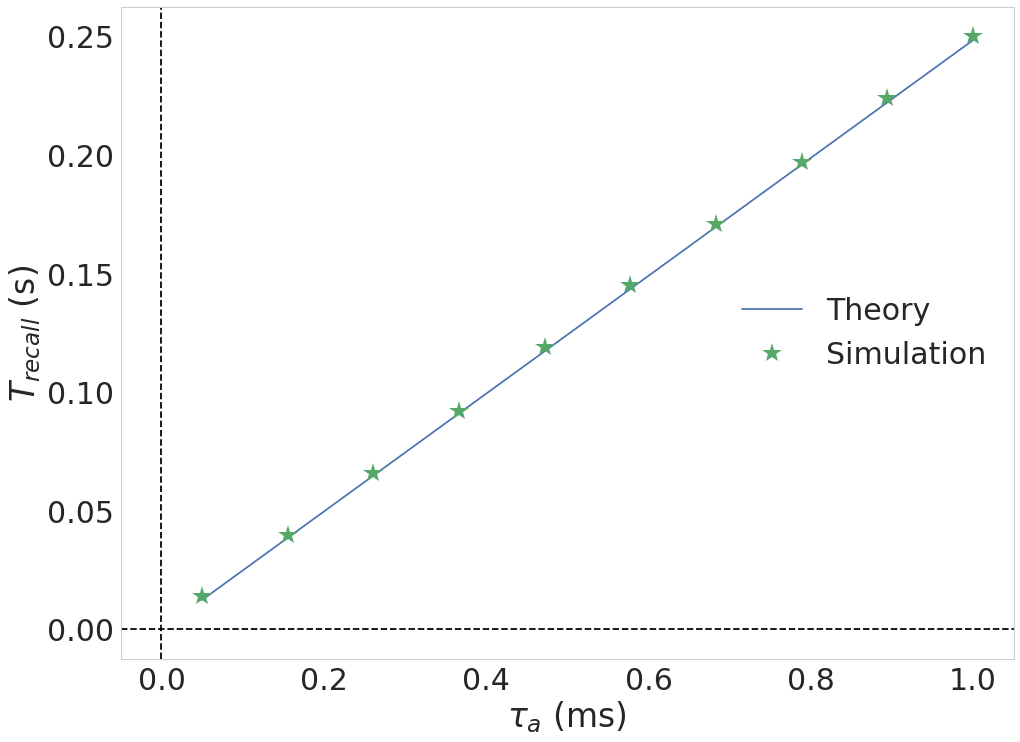

In [17]:
T_recall_theorical_tau_a = simple_bcpnn_theo_recall_time(tau_a_vector, g_a, g_w_ampa, w_next, w_self)

fig = plt.figure(figsize=(16, 12))
ax1 = fig.add_subplot(111)
ax1.plot(tau_a_vector, T_recall_theorical_tau_a, '-', label=r'Theory')
ax1.plot(tau_a_vector, T_recall_vector_tau_a, '*', markersize=20, label=r'Simulation')

ax1.axhline(0, ls='--', color='black')
ax1.axvline(0, ls='--', color='black')
ax1.set_xlabel(r'$\tau_{a}$ (ms)')
ax1.set_ylabel(r'$T_{recall}$ (s)')
ax1.legend();

#### g_a

In [18]:
# Patterns parameters
hypercolumns = 1
minicolumns = 10
n_patterns = 10

# Manager properties
dt = 0.001
values_to_save = ['o', 's', 'z_pre', 'z_post', 'a', 'i_ampa', 'i_nmda']
    
g_a_vector = g_w_ampa * (w_self - w_next) + np.logspace(0, 1.2, 20) * 0.5
T_recall_vector_g_a = np.zeros_like(g_a_vector)
success_g_a = np.zeros_like(g_a_vector)
std_g_a = np.zeros_like(g_a_vector)

for index, g_a_ in enumerate(g_a_vector):
    
    # Build the network
    nn = BCPNNPefect(hypercolumns, minicolumns, g_w_ampa=g_w_ampa, g_w=g_w, g_a=g_a_, tau_a=tau_a, 
                      sigma=sigma, G=G,
                    z_transfer=False, diagonal_zero=False, strict_maximum=True, perfect=True)

    # Build the manager
    manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)
    w = simple_bcpnn_matrix(minicolumns, w_self, w_next, w_rest)
    nn.w_ampa = w

    # Recall
    T_recall = 4.0
    T_cue = 0.100
    sequences = [[i for i in range(n_patterns)]]
    n = 1

    aux = calculate_recall_time_quantities(manager, T_recall, T_cue, n, sequences)
    total_sequence_time, mean, std, success, timings = aux
    
    T_recall_vector_g_a[index] = mean
    success_g_a[index] = success
    std_g_a[index] = std
    

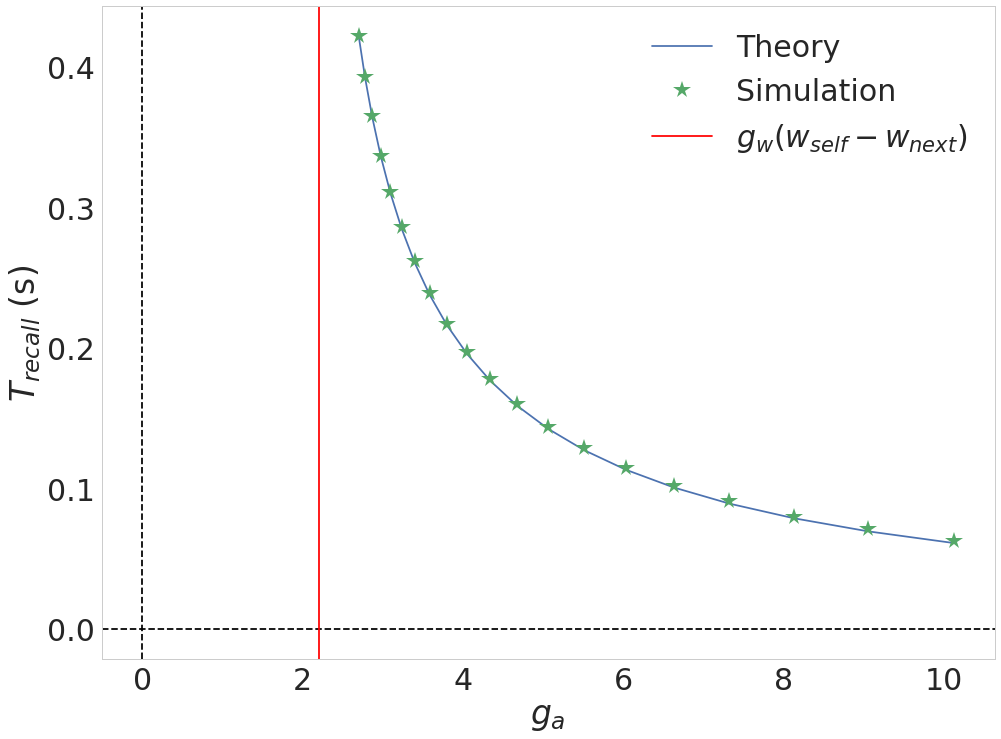

In [19]:
T_recall_theoretical_g_a = simple_bcpnn_theo_recall_time(tau_a, g_a_vector, g_w_ampa, w_next, w_self)
singularity = g_w_ampa * (w_self - w_next)

fig = plt.figure(figsize=(16, 12))
ax2 = fig.add_subplot(111)

ax2.plot(g_a_vector, T_recall_theoretical_g_a, '-', label=r'Theory')
ax2.plot(g_a_vector, T_recall_vector_g_a, '*', markersize=20,  label=r'Simulation')
ax2.axhline(0, ls='--', color='black')
ax2.axvline(0, ls='--', color='black')
ax2.axvline(singularity, ls='-', color='red', label=r'$g_{w}(w_{self} - w_{next})$')

ax2.set_xlabel(r'$g_{a}$')
ax2.set_ylabel(r'$T_{recall}$ (s)')
ax2.legend();

#### g_w

In [20]:
# Patterns parameters
hypercolumns = 1
minicolumns = 10
n_patterns = 10

# Manager properties
dt = 0.001
values_to_save = ['o', 's', 'z_pre', 'z_post', 'a', 'i_ampa', 'i_nmda']

g_w_max = g_a / (w_self - w_next)
g_w_ampa_vector = g_w_max - np.logspace(-1, 1, 20) * 0.9
T_recall_vector_g_w = np.zeros_like(g_w_ampa_vector)
success_g_w = np.zeros_like(g_w_ampa_vector)
std_g_w = np.zeros_like(g_w_ampa_vector)

for index, g_w_ampa_ in enumerate(g_w_ampa_vector):
    
    # Build the network
    nn = BCPNNPefect(hypercolumns, minicolumns, g_w_ampa=g_w_ampa_, g_w=g_w, g_a=g_a, tau_a=tau_a, 
                      sigma=sigma, G=G,
                    z_transfer=False, diagonal_zero=False, strict_maximum=True, perfect=True)

    # Build the manager
    manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)
    w = simple_bcpnn_matrix(minicolumns, w_self, w_next, w_rest)
    nn.w_ampa = w

    # Recall
    T_recall = 5.0
    T_cue = 0.100
    sequences = [[i for i in range(n_patterns)]]
    n = 1

    aux = calculate_recall_time_quantities(manager, T_recall, T_cue, n, sequences)
    total_sequence_time, mean, std, success, timings = aux
    
    T_recall_vector_g_w[index] = mean
    success_g_w[index] = success
    std_g_w[index] = std
    

/home/heberto/miniconda/envs/python3/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/heberto/miniconda/envs/python3/lib/python3.5/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/heberto/miniconda/envs/python3/lib/python3.5/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/heberto/miniconda/envs/python3/lib/python3.5/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/heberto/miniconda/envs/python3/lib/python3.5/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


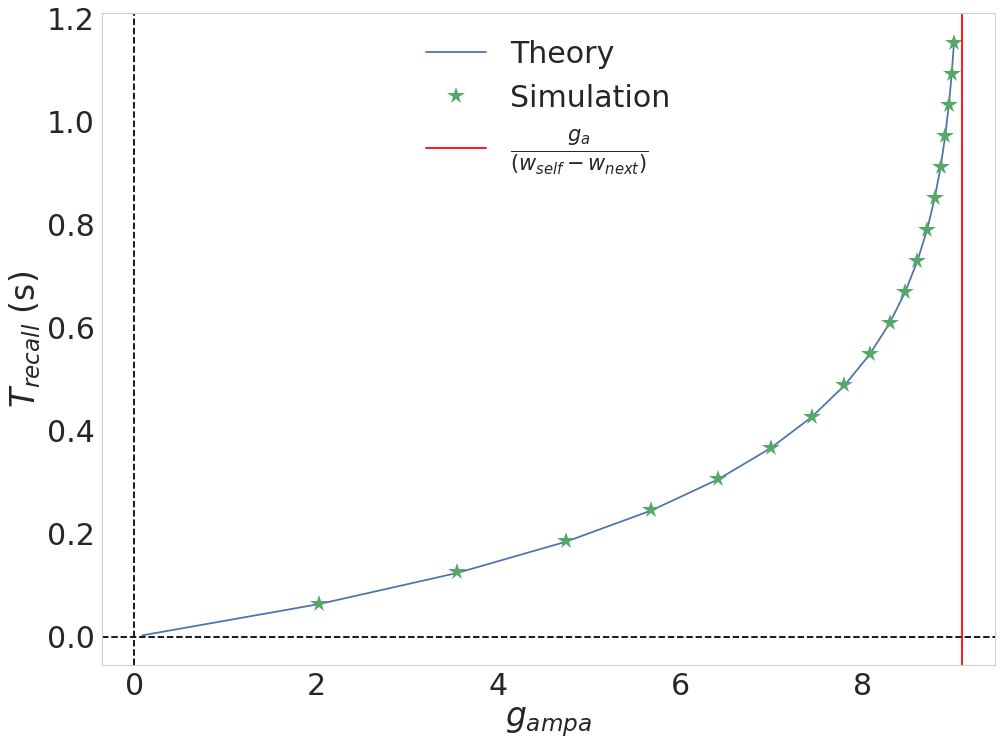

In [21]:
T_recall_theorical_g_w_ampa = simple_bcpnn_theo_recall_time(tau_a, g_a, g_w_ampa_vector, w_next, w_self)

fig = plt.figure(figsize=(16, 12))

ax3 = fig.add_subplot(111)
ax3.plot(g_w_ampa_vector, T_recall_theorical_g_w_ampa, '-', label=r'Theory')
ax3.plot(g_w_ampa_vector, T_recall_vector_g_w, '*', markersize=20, label=r'Simulation')
ax3.axhline(0, ls='--', color='black')
ax3.axvline(0, ls='--', color='black')
ax3.axvline(g_w_max, ls='-', color='red', label=r'$\frac{g_{a}}{(w_{self} - w_{next})}$')
ax3.set_xlabel(r'$g_{ampa}$')
ax3.set_ylabel(r'$T_{recall}$ (s)')
ax3.legend();

#### g_next

In [32]:
# Patterns parameters
hypercolumns = 1
minicolumns = 10
n_patterns = 10

# Manager properties
dt = 0.001
values_to_save = ['o', 's', 'z_pre', 'z_post', 'a', 'i_ampa', 'i_nmda']

w_next_max = w_self
w_next_min = w_self - g_a / g_w_ampa 
w_next_vector = (w_next_max - w_next_min) * np.logspace(-2, 0, 20) + w_next_min
T_recall_vector_w_next = np.zeros_like(w_next_vector)
success_w_next = np.zeros_like(w_next_vector)
std_w_next = np.zeros_like(w_next_vector)

for index, w_next_ in enumerate(w_next_vector):
    
    # Build the network
    nn = BCPNNPefect(hypercolumns, minicolumns, g_w_ampa=g_w_ampa, g_w=g_w, g_a=g_a, tau_a=tau_a, 
                      sigma=sigma, G=G,
                    z_transfer=False, diagonal_zero=False, strict_maximum=True, perfect=True)

    # Build the manager
    manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)
    w = simple_bcpnn_matrix(minicolumns, w_self, w_next_, w_next_min - 1.0)
    nn.w_ampa = w

    # Recall
    T_recall = 5.0
    T_cue = 0.100
    sequences = [[i for i in range(n_patterns)]]
    n = 1

    aux = calculate_recall_time_quantities(manager, T_recall, T_cue, n, sequences)
    total_sequence_time, mean, std, success, timings = aux
    
    T_recall_vector_w_next[index] = mean
    success_w_next[index] = success
    std_w_next[index] = std
    

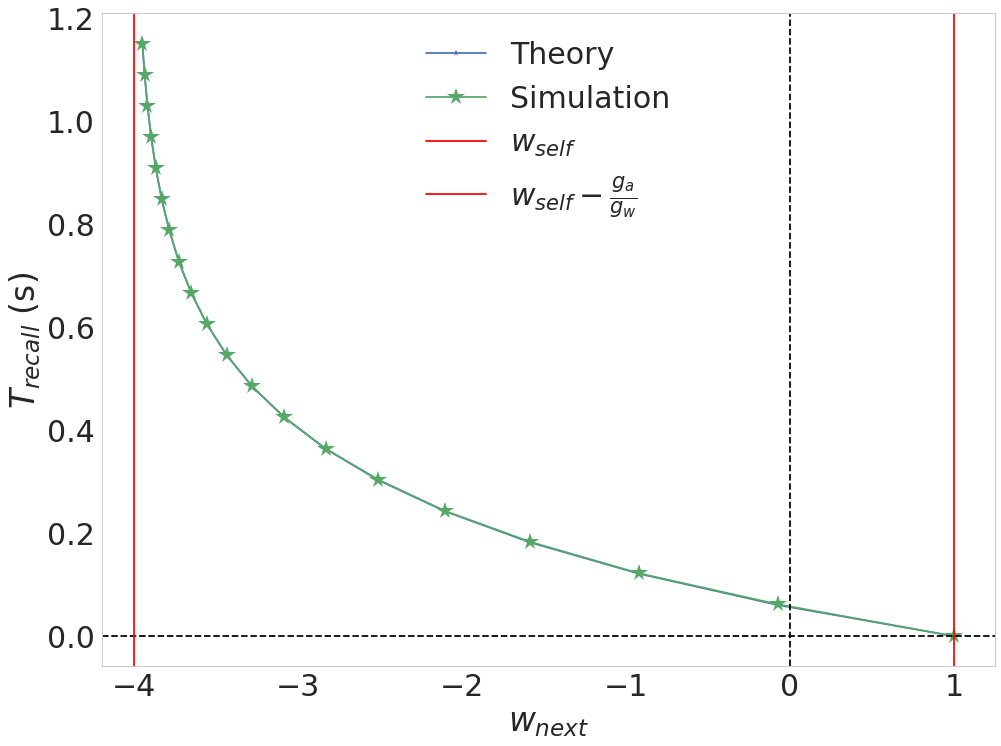

In [33]:
T_recall_theorical_w_next = simple_bcpnn_theo_recall_time(tau_a, g_a, g_w_ampa, w_next_vector, w_self)

fig = plt.figure(figsize=(16, 12))

ax4 = fig.add_subplot(111)
ax4.plot(w_next_vector, T_recall_theorical_w_next, '*-', label=r'Theory')
ax4.plot(w_next_vector, T_recall_vector_w_next, '*-', markersize=18, label=r'Simulation')

ax4.axhline(0, ls='--', color='black')
ax4.axvline(0, ls='--', color='black')
ax4.set_xlabel(r'$w_{next}$')
ax4.set_ylabel(r'$T_{recall}$ (s)')
ax4.axvline(w_next_max, ls='-', color='red', label=r'$w_{self}$')
ax4.axvline(w_next_min, ls='-', color='red', label=r'$w_{self} - \frac{g_a}{g_w}$')
ax4.legend();
